<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sys
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from zipfile import ZipFile
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import bfseg.models.fast_scnn
import bfseg.data.hive.office_rumlang_validation_labeled
import bfseg.data.hive.bfseg_validation_labeled
from bfseg.utils.utils import load_gdrive_file
#from bfseg.settings import TMPDIR
TMPDIR = "/home/matthias/data/rss_2021_data/tmp/"
MASKPATH = "/home/matthias/data/rss_2021_data/mask.png"

Segmentation Models: using `tf.keras` framework.


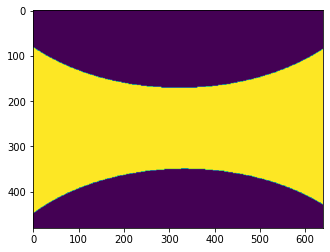

In [2]:
# Load mask
mask = plt.imread(MASKPATH)
ax = plt.subplot()
ax.imshow(mask)
mask_filtered = np.nonzero(mask)
test = mask[mask_filtered]

In [4]:
# Settings:
val_ds_office_gt = tfds.load('office_rumlang_validation_labeled', split='OFFICE')

In [5]:
nyu_depth_ds = tfds.load("NyuDepthV2LabeledDepth", split="full[:1%]")

## NYU Pretraining Results - no depth

In [64]:
directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_pretraining_1/'

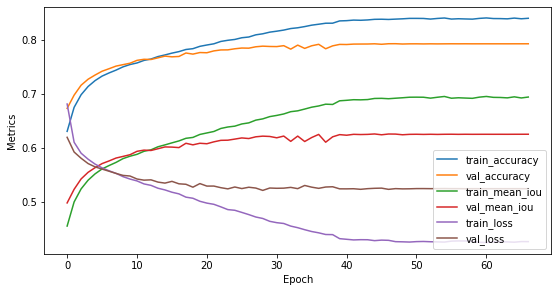

In [9]:
# Graph
log_file = os.path.join(directory, 'metrics.json')
with open(log_file) as f:
    data = json.load(f)
figure1 = plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1) 
ax.set_xlabel("Epoch")
ax.set_ylabel("Metrics")
for metric in ['train_accuracy', 'val_accuracy', 'train_mean_iou', 'val_mean_iou', 'train_loss', 'val_loss']:
    epoch = data[metric]['steps']
    metric_values = data[metric]['values']
    line, = ax.plot(epoch, metric_values)
    line.set_label(metric)    
ax.legend(loc=4)

In [65]:
# Office GT Validation
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_10.h5'))

miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)
    pred = tf.argmax(b[1], axis=-1)
    miou.update_state(batch['label'], pred, mask)
print("With mask: {}".format(miou.result()))
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)
    pred = tf.argmax(b[1], axis=-1)
    miou.update_state(batch['label'], pred)
print("Without mask: {}".format(miou.result()))

With mask: 0.47918570041656494
Without mask: 0.4417223334312439


In [12]:
# Save model weights:
#model0.save_weights('/home/matthias/data/rss_2021_data/xavier_models/nyu_pretrained_weights_10.h5')

## NYU Pretraining Results - depth

In [5]:
from scipy import stats
def ignorant_depth_loss(depth_label, y_pred_depth, maxDepthVal=1000.0 / 10.0): 
    """
    wrapper to mask all "NaN" values in depth
    """
    y_pred_depth_ignorant = tf.where(tf.math.is_nan(depth_label),
                                     tf.zeros_like(depth_label), y_pred_depth)
    depth_label = tf.where(tf.math.is_nan(depth_label),
                           tf.zeros_like(depth_label), depth_label)
    #print("Ignorant depth loss: ")
    #print("depth_label: {}".format(depth_label))
    #print("y_pred_depth_ignorant: {}".format(y_pred_depth_ignorant))

    return depth_loss_function(depth_label, y_pred_depth_ignorant, maxDepthVal=maxDepthVal)


def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0 / 10.0): 
    """ Loss Function from DenseDepth paper.
      Code taken from here https://github.com/ialhashim/DenseDepth/blob/master/loss.py
    """

    # Point-wise depth
    l_depth = tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true),
                                    axis=-1)
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = tf.keras.backend.mean(tf.keras.backend.abs(dy_pred - dy_true) +
                                    tf.keras.backend.abs(dx_pred - dx_true),
                                    axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = tf.keras.backend.clip(
        (1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * tf.keras.backend.mean(l_edges)) + (
        w3 * tf.keras.backend.mean(l_depth))

def tf_boxcox(input):
    y = tf.numpy_function(stats.boxcox, [input], (tf.float32, tf.float64))
    return y 

def ignorant_standardization(x):
    valid_pixels = tf.where(tf.math.is_nan(x), 
                            tf.constant(0, dtype=tf.float32), tf.constant(1, dtype=tf.float32))
    num_pixels = tf.reduce_sum(valid_pixels)
    nan_mask = tf.math.logical_not(tf.math.is_nan(x))
    x_nonans = tf.boolean_mask(x, nan_mask)
    nanmean = tf.math.reduce_mean(x_nonans)
    nanstd = tf.math.reduce_std(x_nonans)
    min_nanstd = tf.math.rsqrt(num_pixels)
    adjusted_nanstd = tf.math.maximum(min_nanstd, nanstd)
    x_standardized = x - nanmean
    x_standardized = tf.math.divide(x_standardized, adjusted_nanstd)
    return x_standardized, nanmean, adjusted_nanstd

def preprocess_boxcox_standardize(depth_label_orig):
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    #depth_norm_2 = 10 / depth_norm_2
    
    # boxcox in 1D
    old_shape = depth_norm_2.shape
    depth_flattened = tf.reshape(depth_norm_2, [-1])
    depth_flattened_trans, boxcox_lambda  = tf_boxcox(depth_flattened)
    depth_restored = tf.reshape(depth_flattened_trans, old_shape)
    
    # standardize
    depth_standardized = tf.image.per_image_standardization(depth_restored)
    return depth_standardized, boxcox_lambda

def preprocess_inverse_median(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)
    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (inverse + median (4.03) scaling)
    depth_norm_2 = 10 / depth_norm_2 - 4.03 
    return depth_norm_2

def preprocess_power_median(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)

    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (power (lambda = 0.54) + median (1.29) scaling)
    depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54 - 1.29
    return depth_norm_2

def preprocess_power_standardize(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)

    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (power (lambda = 0.54) + median (1.29) scaling)
    depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54
    depth_standardized, _, _ = ignorant_standardization(depth_norm_2)
    return depth_standardized

def preprocess_inverse_standardize(depth_label_orig):
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = 10 / depth_norm_2
    depth_standardized = tf.image.per_image_standardization(depth_norm_2)
    return depth_standardized

### Inverse (+ standardize)

In [124]:
#directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_1/'
directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_10/'

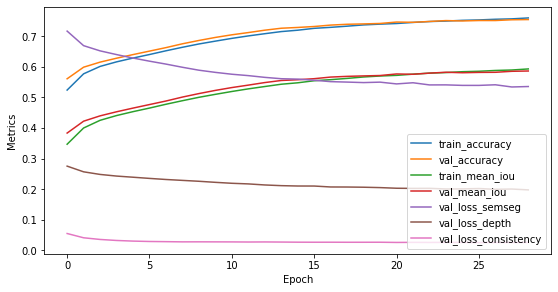

In [125]:
# Graph
log_file = os.path.join(directory, 'metrics.json')
with open(log_file) as f:
    data = json.load(f)
figure1 = plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1) 
ax.set_xlabel("Epoch")
ax.set_ylabel("Metrics")
# removed 'train_loss' and 'val_loss'
for metric in ['train_accuracy', 'val_accuracy', 'train_mean_iou', 'val_mean_iou', 'val_loss_semseg', 'val_loss_depth', 'val_loss_consistency']:
    epoch = data[metric]['steps']
    metric_values = data[metric]['values']
    line, = ax.plot(epoch, metric_values)
    line.set_label(metric)    
ax.legend(loc=4)

With mask: 0.46730268001556396
Without mask: 0.4881249666213989


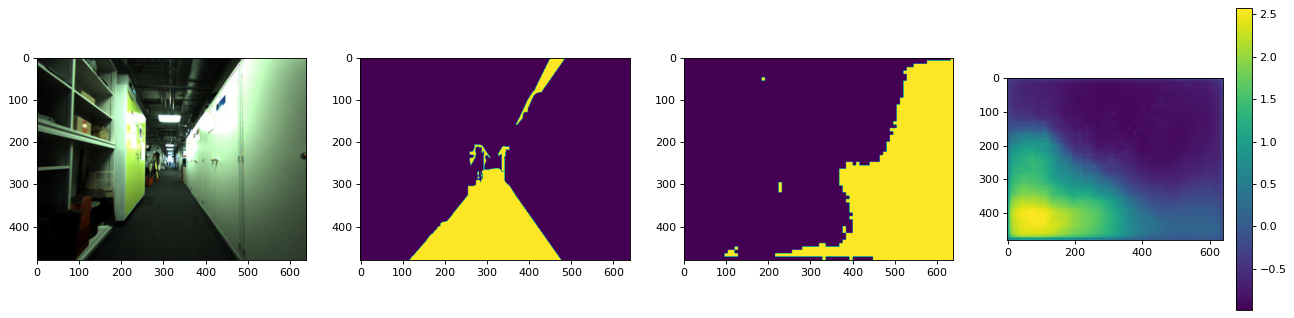

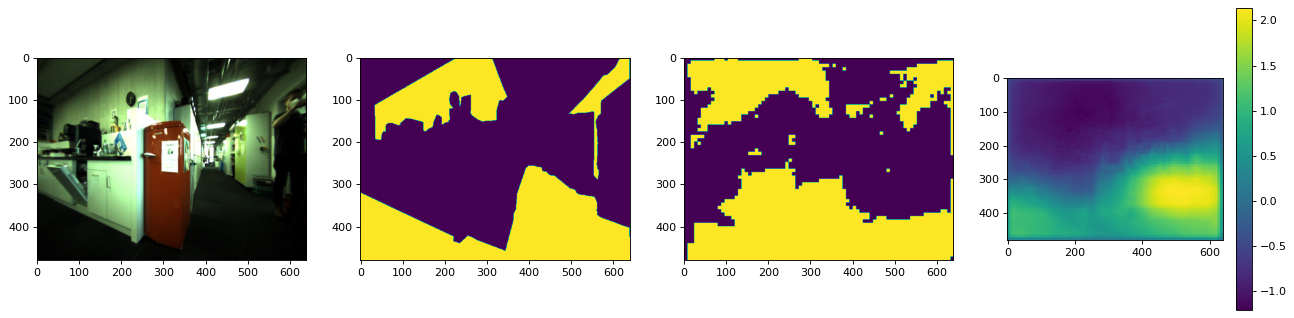

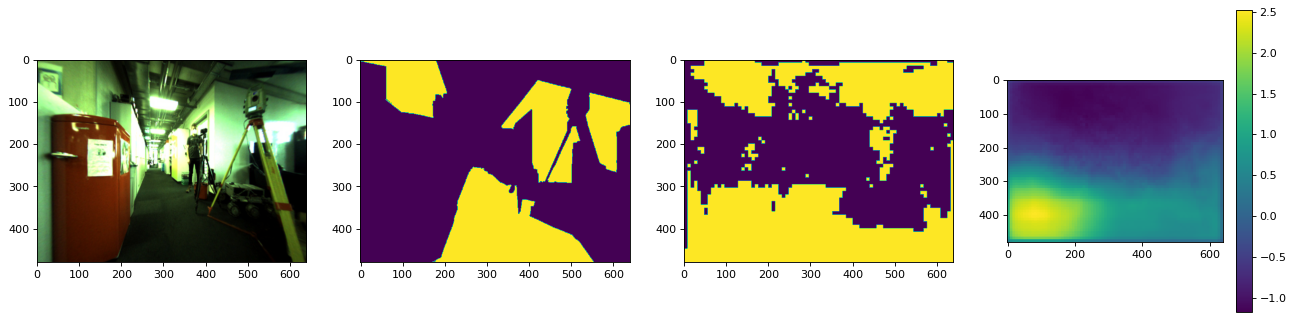

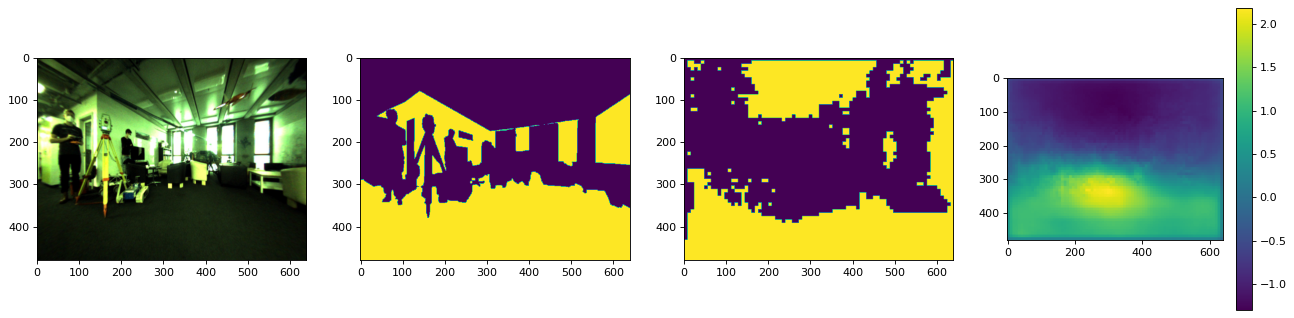

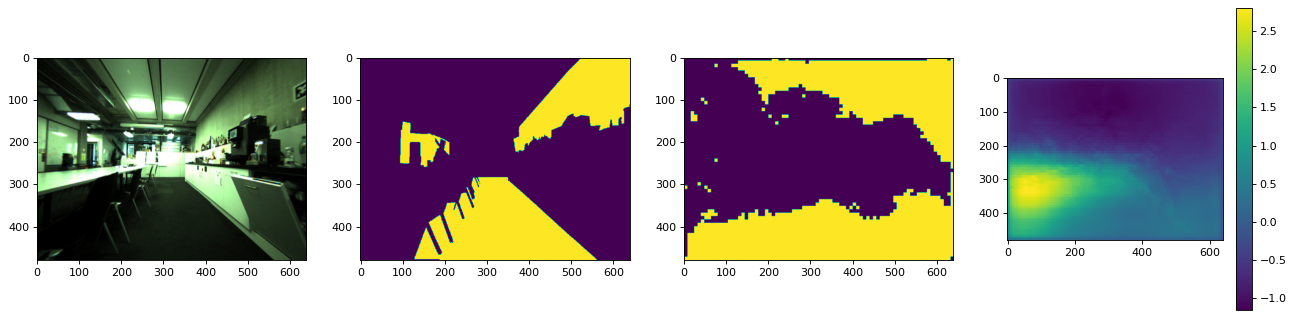

In [127]:
# Office GT Validation
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_20.h5'), custom_objects={'tf': tf})
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred, mask)
print("With mask: {}".format(miou.result()))
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred)
print("Without mask: {}".format(miou.result()))

for entry in val_ds_office_gt.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(entry['image'])
    plt.subplot(1,4,2)
    plt.imshow(entry['label'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,4,3)
    plt.imshow(pred[0,:,:])
    plt.subplot(1,4,4)
    ax = plt.imshow(depth[0,:,:])
    figure.colorbar(ax)

tf.Tensor([0.23779225], shape=(1,), dtype=float32)
tf.Tensor([0.15993488], shape=(1,), dtype=float32)
tf.Tensor([0.24802087], shape=(1,), dtype=float32)
tf.Tensor([0.15202205], shape=(1,), dtype=float32)
tf.Tensor([0.09992339], shape=(1,), dtype=float32)


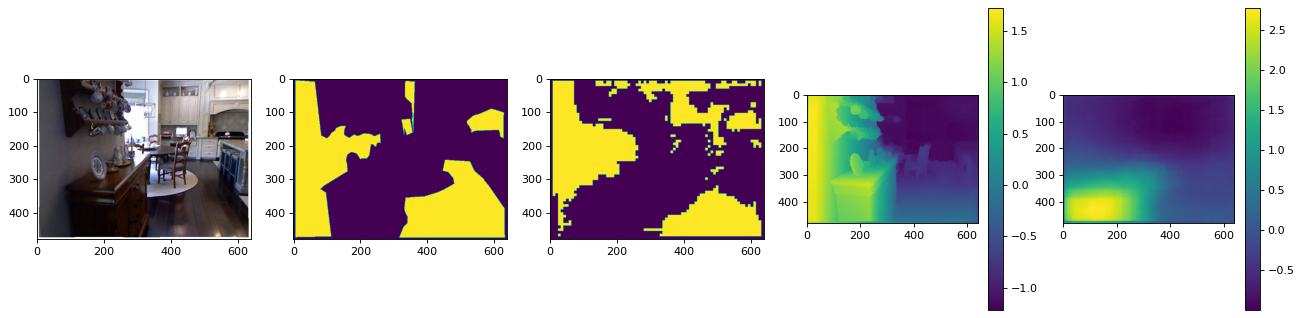

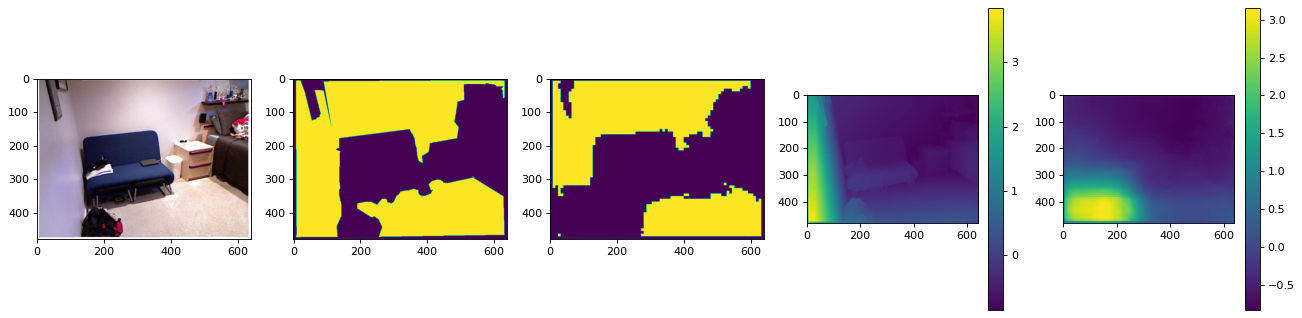

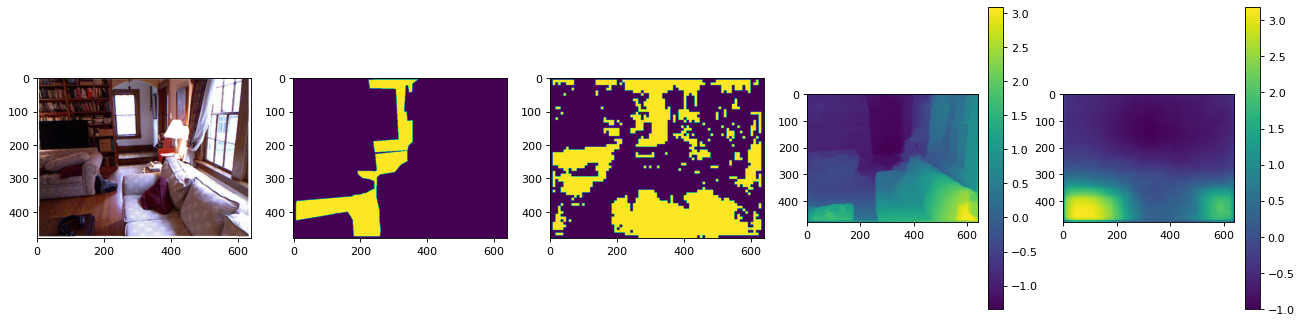

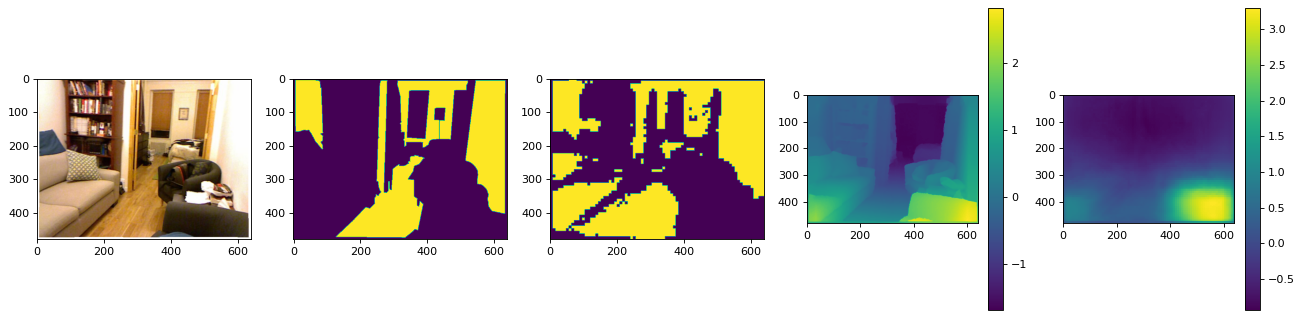

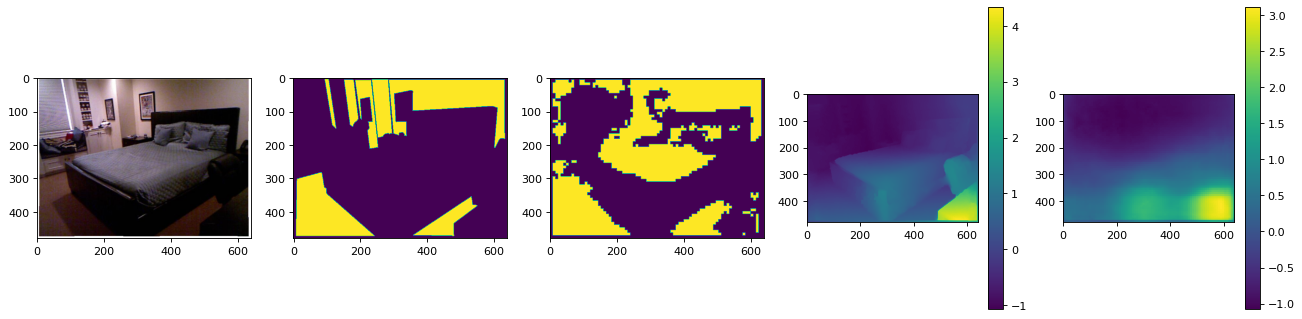

In [102]:
# inverse (+ standardize)
standardize = True
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_10.h5'), custom_objects={'tf': tf})
for entry in nyu_depth_ds.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,5,1)
    plt.imshow(entry['image'])
    plt.subplot(1,5,2)
    plt.imshow(entry['label']['seg'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    # Depth label
    plt.subplot(1,5,4)
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_norm_2 = preprocess_inverse_standardize(depth_label_orig)
    ax1 = plt.imshow(depth_norm_2)
    figure.colorbar(ax1)
    label_depth = tf.expand_dims(depth_norm_2,0)
    # Depth predictions
    plt.subplot(1,5,5)
    ax2 = plt.imshow(depth[0,:,:])
    figure.colorbar(ax2)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    #pred_depth = tf.keras.activations.relu(pred_depth)
    
    print(ignorant_depth_loss(label_depth, pred_depth))

In [104]:
# Save model weights:
#model0.save_weights('/media/matthias/sandisk/saved_weights/nyu_depth_inverse_pretrained_weights_20.h5')

### BoxCox + Standardize

In [105]:
#directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_9/'
directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_9/'

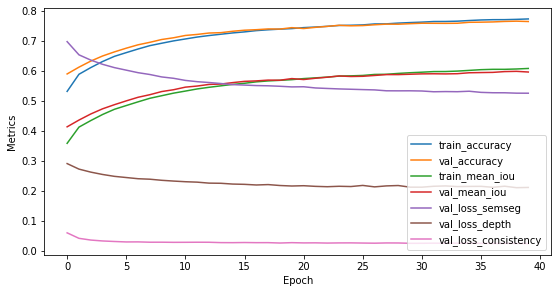

In [106]:
# Graph
log_file = os.path.join(directory, 'metrics.json')
with open(log_file) as f:
    data = json.load(f)
figure1 = plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1) 
ax.set_xlabel("Epoch")
ax.set_ylabel("Metrics")
# removed 'train_loss' and 'val_loss'
for metric in ['train_accuracy', 'val_accuracy', 'train_mean_iou', 'val_mean_iou', 'val_loss_semseg', 'val_loss_depth', 'val_loss_consistency']:
    epoch = data[metric]['steps']
    metric_values = data[metric]['values']
    line, = ax.plot(epoch, metric_values)
    line.set_label(metric)    
ax.legend(loc=4)

With mask: 0.41973114013671875
Without mask: 0.44803500175476074


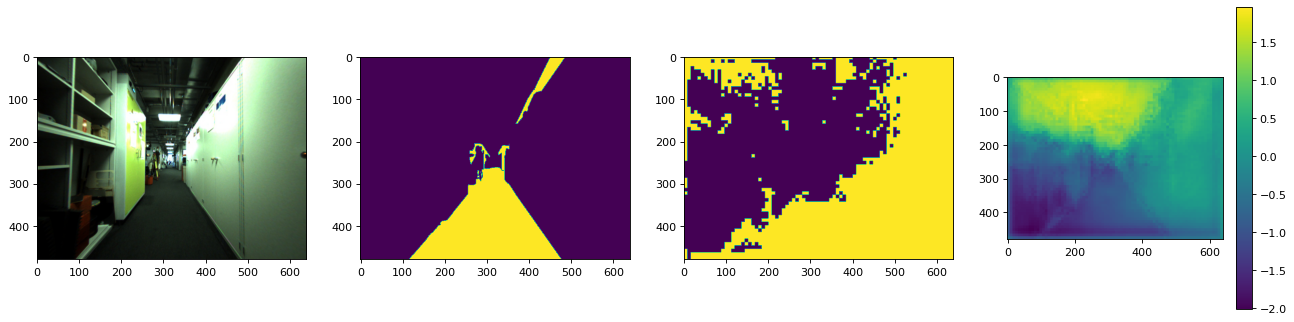

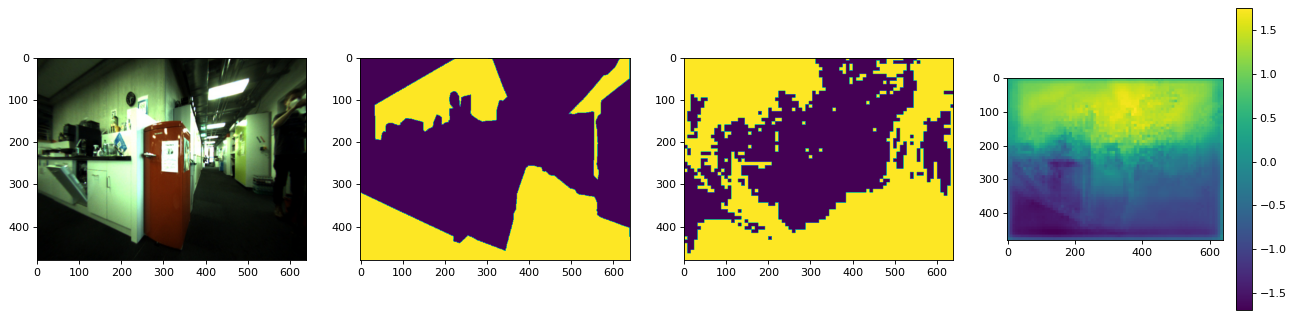

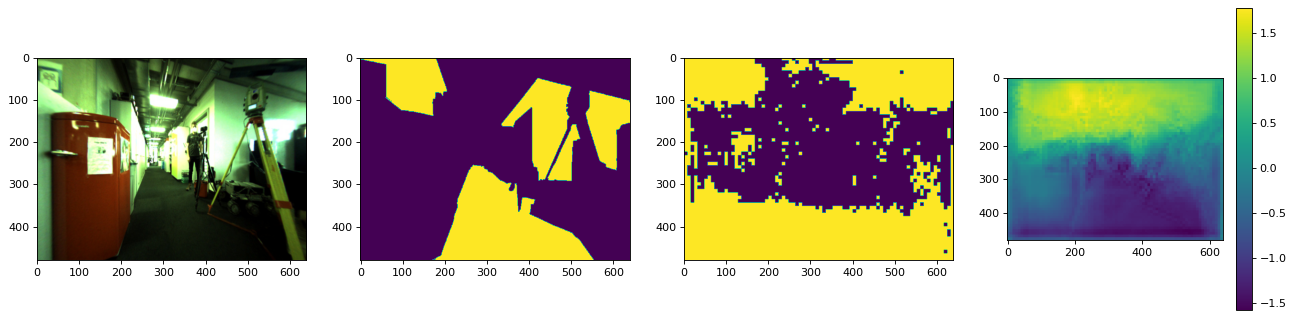

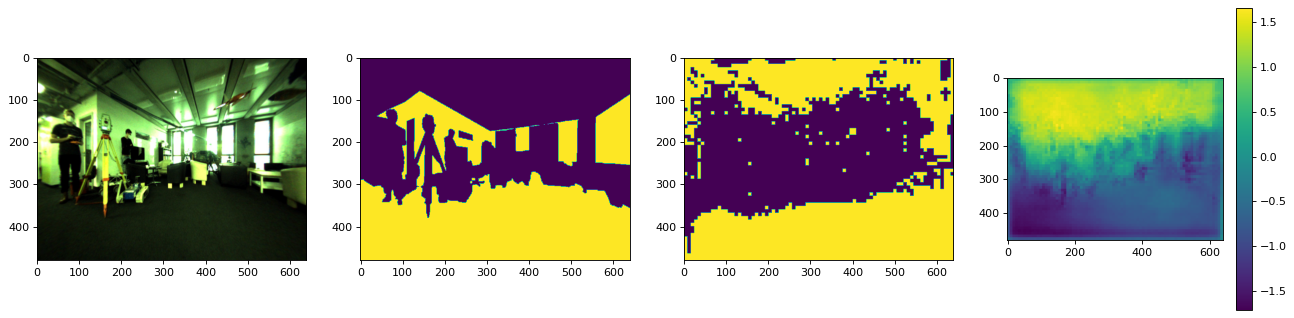

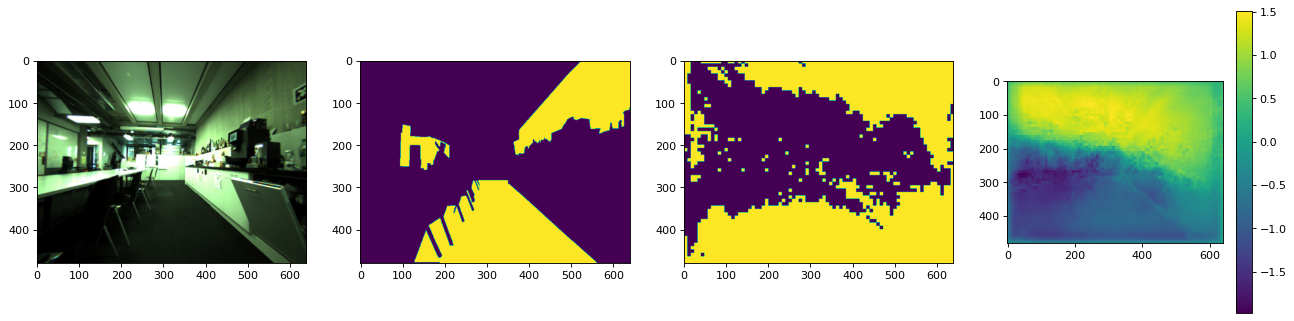

In [107]:
# Office GT Validation
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_20.h5'), custom_objects={'tf': tf})
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred, mask)
print("With mask: {}".format(miou.result()))
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred)
print("Without mask: {}".format(miou.result()))

for entry in val_ds_office_gt.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(entry['image'])
    plt.subplot(1,4,2)
    plt.imshow(entry['label'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,4,3)
    plt.imshow(pred[0,:,:])
    plt.subplot(1,4,4)
    ax = plt.imshow(depth[0,:,:])
    figure.colorbar(ax)

In [94]:
# Save model weights:
#model0.save_weights('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretrained_weights_20.h5')

tf.Tensor([0.18442938], shape=(1,), dtype=float32)
tf.Tensor([0.14951706], shape=(1,), dtype=float32)
tf.Tensor([0.22658488], shape=(1,), dtype=float32)
tf.Tensor([0.11279817], shape=(1,), dtype=float32)
tf.Tensor([0.11809584], shape=(1,), dtype=float32)


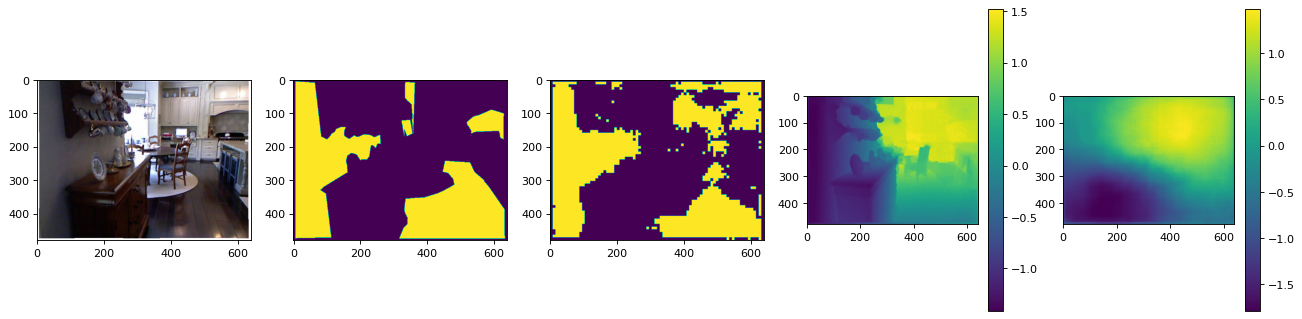

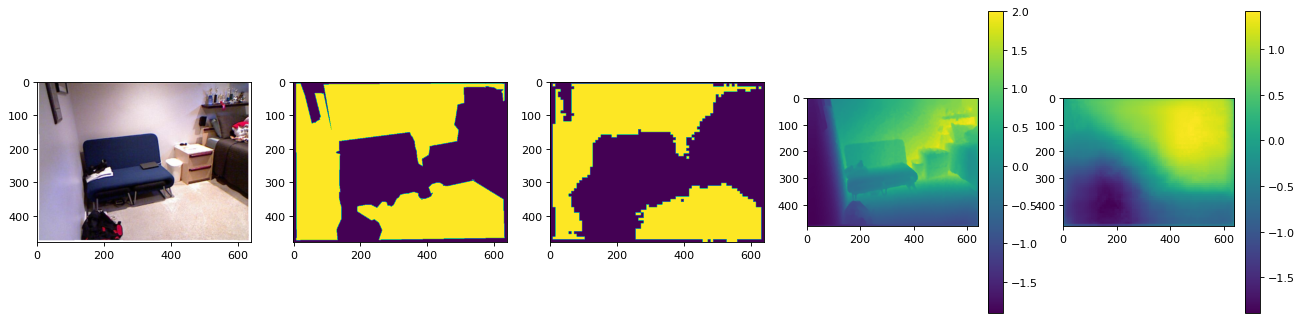

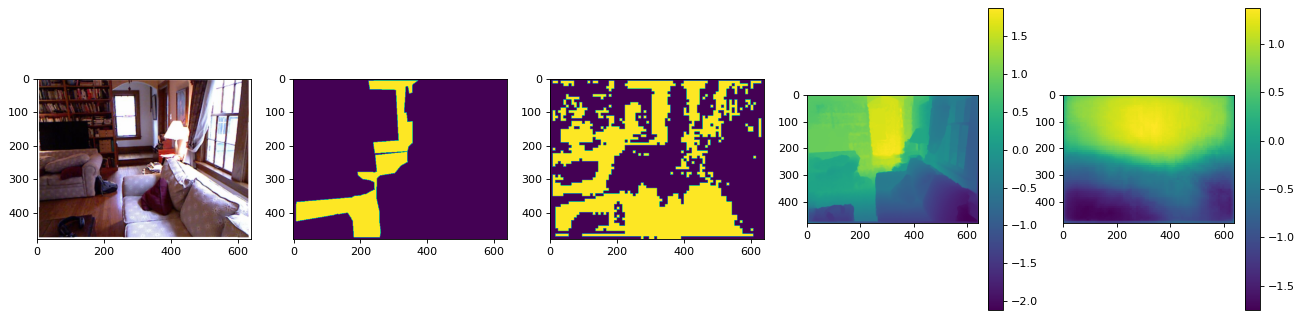

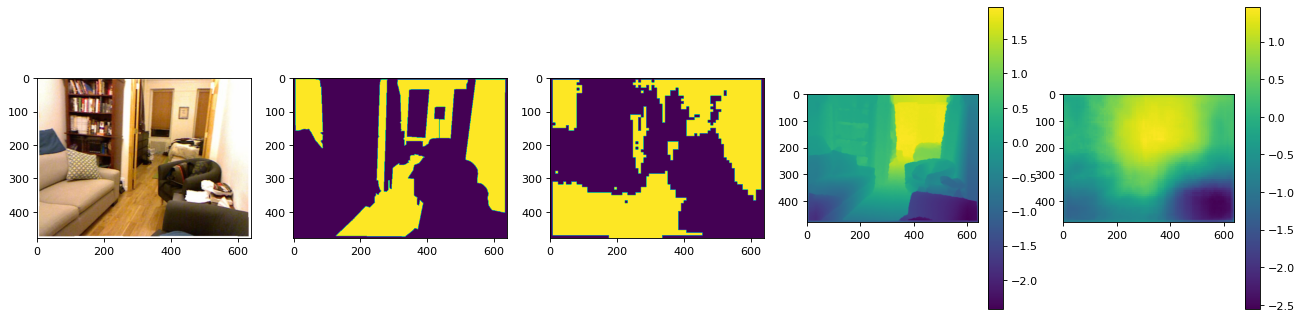

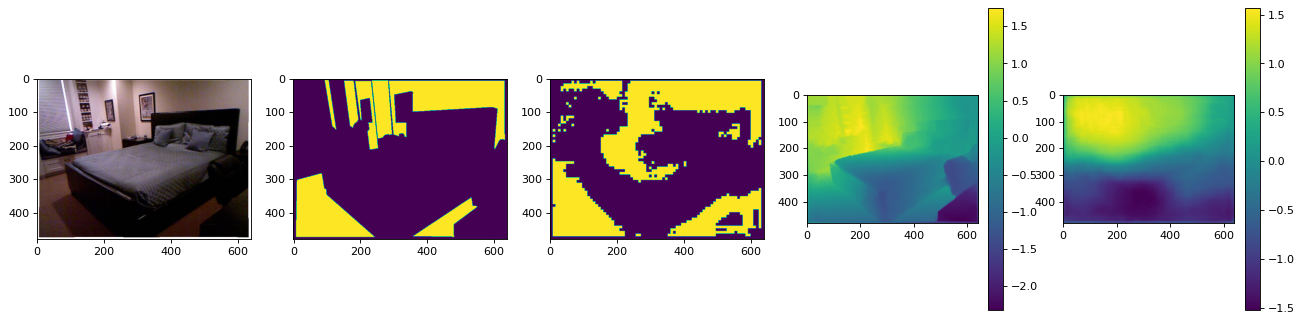

In [110]:
# BoxCox + standardize
 
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_20.h5'), custom_objects={'tf': tf})
for entry in nyu_depth_ds.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,5,1)
    plt.imshow(entry['image'])
    plt.subplot(1,5,2)
    plt.imshow(entry['label']['seg'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    # Depth label
    plt.subplot(1,5,4)
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_standardized, _ = preprocess_boxcox_standardize(depth_label_orig)
    
    ax1 = plt.imshow(depth_standardized)
    figure.colorbar(ax1)
    label_depth = tf.expand_dims(depth_standardized,0)
    
    # Depth predictions
    plt.subplot(1,5,5)
    ax2 = plt.imshow(depth[0,:,:])
    figure.colorbar(ax2)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    #pred_depth = tf.keras.activations.relu(pred_depth)
    
    print(ignorant_depth_loss(label_depth, pred_depth))

### Power + Median

In [16]:
directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_13/' # 65
#directory = '/home/matthias/data/rss_2021_data/xavier_models/office3_densedepth20_dyn_cam2_finetuning_2/' # 6

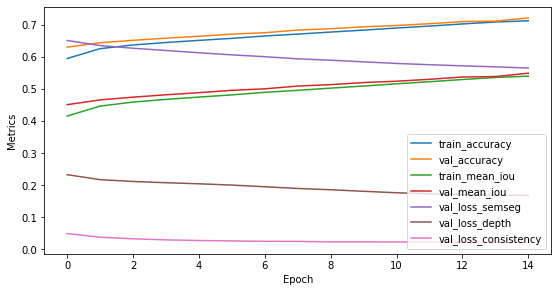

In [17]:
# Graph
log_file = os.path.join(directory, 'metrics.json')
with open(log_file) as f:
    data = json.load(f)
figure1 = plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1) 
ax.set_xlabel("Epoch")
ax.set_ylabel("Metrics")
# removed 'train_loss' and 'val_loss'
for metric in ['train_accuracy', 'val_accuracy', 'train_mean_iou', 'val_mean_iou', 'val_loss_semseg', 'val_loss_depth', 'val_loss_consistency']:
    epoch = data[metric]['steps']
    metric_values = data[metric]['values']
    line, = ax.plot(epoch, metric_values)
    line.set_label(metric)    
ax.legend(loc=4)

With mask: 0.4894868731498718
Without mask: 0.4446778893470764


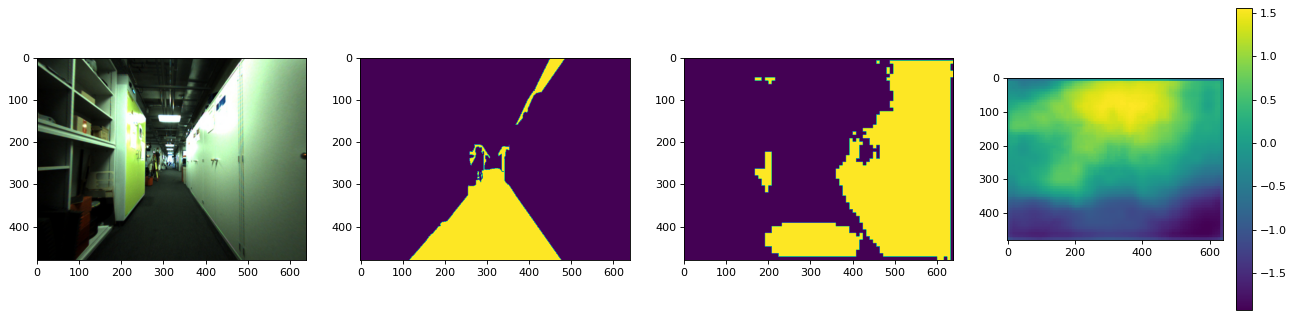

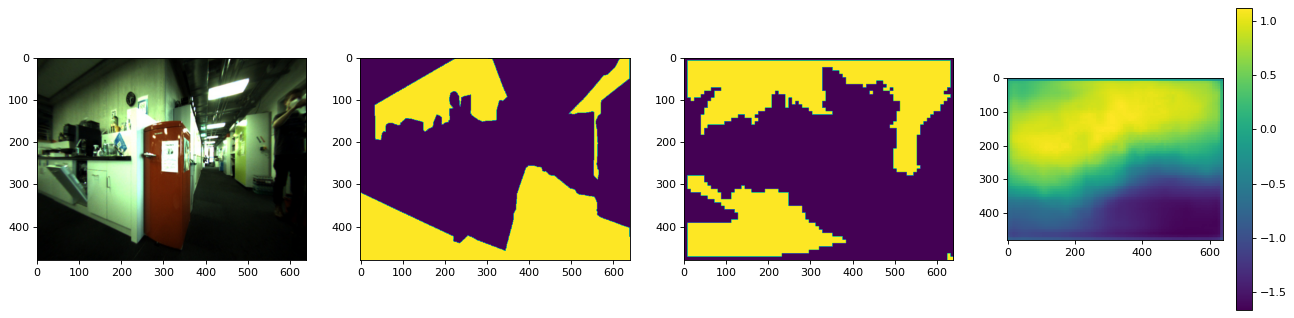

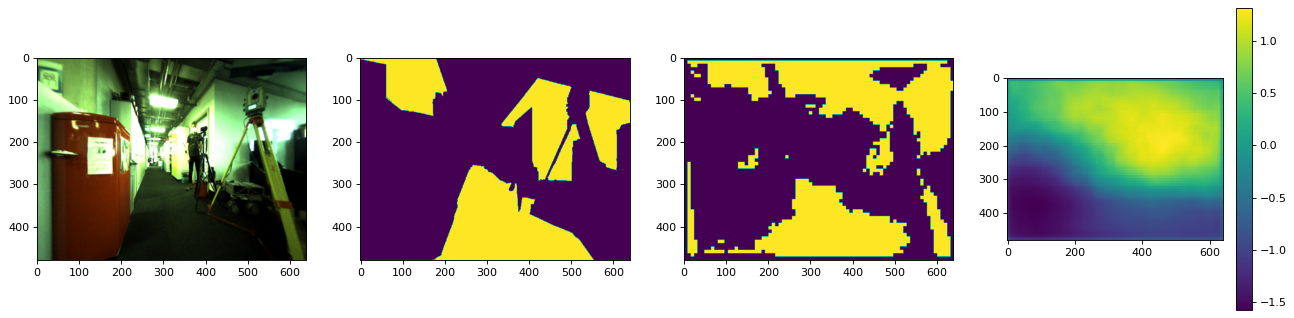

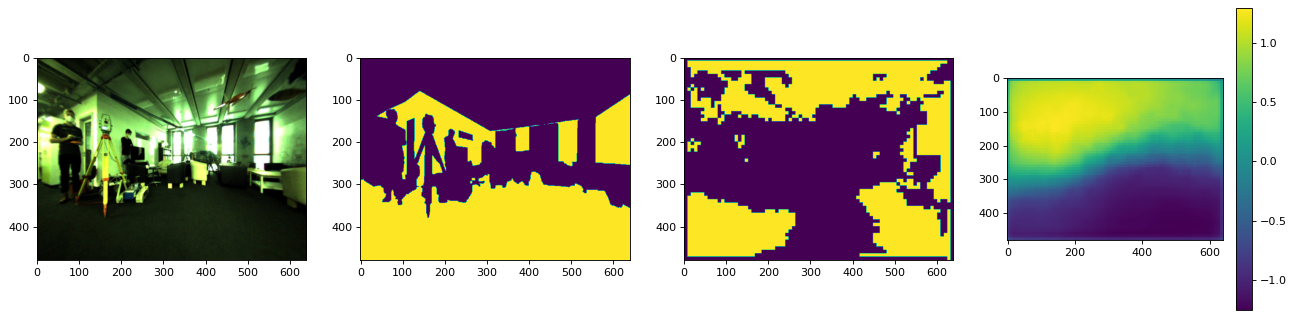

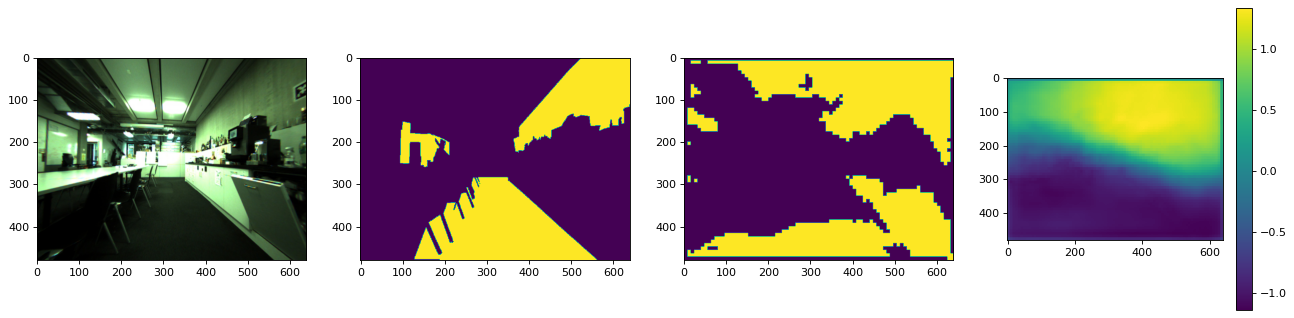

In [11]:
# Office GT Validation
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_65.h5'), custom_objects={'tf': tf})
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred, mask)
print("With mask: {}".format(miou.result()))
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred)
print("Without mask: {}".format(miou.result()))

for entry in val_ds_office_gt.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(entry['image'])
    plt.subplot(1,4,2)
    plt.imshow(entry['label'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,4,3)
    plt.imshow(pred[0,:,:])
    plt.subplot(1,4,4)
    ax = plt.imshow(depth[0,:,:])
    figure.colorbar(ax)

In [160]:
# Save model weights:
#model0.save_weights('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretrained_weights_65.h5')

NameError: name 'preprocess_power_standardize' is not defined

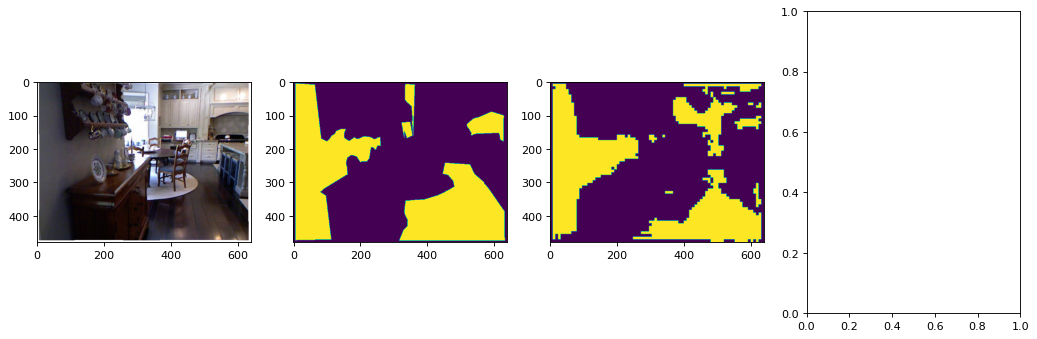

In [161]:
# power + median
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_65.h5'), custom_objects={'tf': tf})
for entry in nyu_depth_ds.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,5,1)
    plt.imshow(entry['image'])
    plt.subplot(1,5,2)
    plt.imshow(entry['label']['seg'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    # Depth label
    plt.subplot(1,5,4)
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_norm_2 = preprocess_power_standardize(depth_label_orig)
    ax1 = plt.imshow(depth_norm_2)
    figure.colorbar(ax1)
    label_depth = tf.expand_dims(depth_norm_2,0)
    # Depth predictions
    plt.subplot(1,5,5)
    ax2 = plt.imshow(depth[0,:,:])
    figure.colorbar(ax2)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    #pred_depth = tf.keras.activations.relu(pred_depth)
    
    # print(ignorant_depth_loss(label_depth, pred_depth))

### Inverse & Squared + 1

In [ ]:
# Office GT Validation
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_20.h5'), custom_objects={'tf': tf})
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred, mask)
print("With mask: {}".format(miou.result()))
miou = tf.keras.metrics.MeanIoU(num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    miou.update_state(batch['label'], pred)
print("Without mask: {}".format(miou.result()))

for entry in val_ds_office_gt.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(entry['image'])
    plt.subplot(1,4,2)
    plt.imshow(entry['label'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,4,3)
    plt.imshow(pred[0,:,:])
    plt.subplot(1,4,4)
    ax = plt.imshow(depth[0,:,:])
    figure.colorbar(ax)

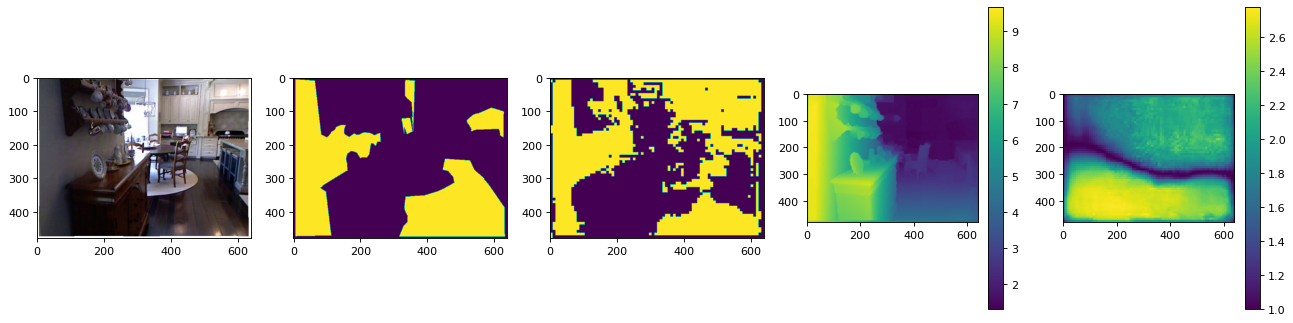

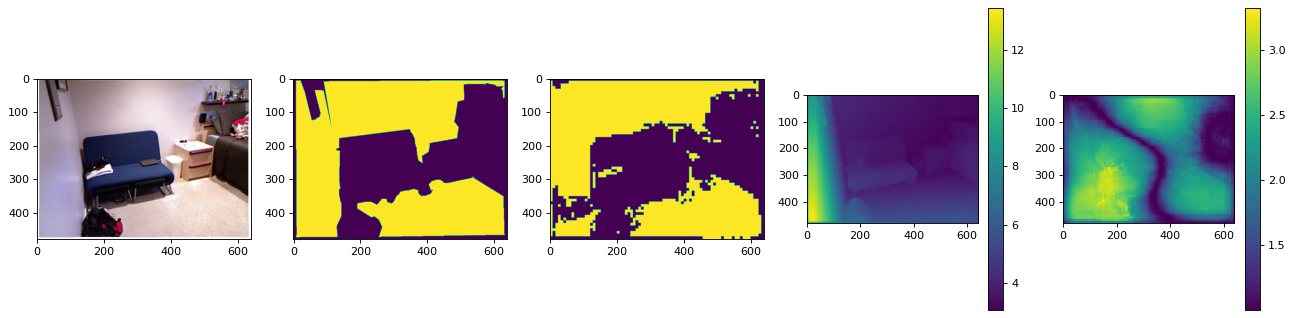

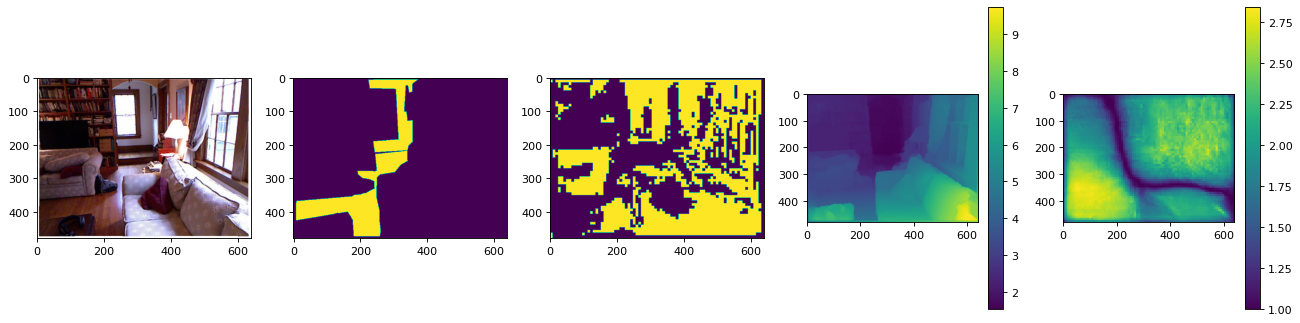

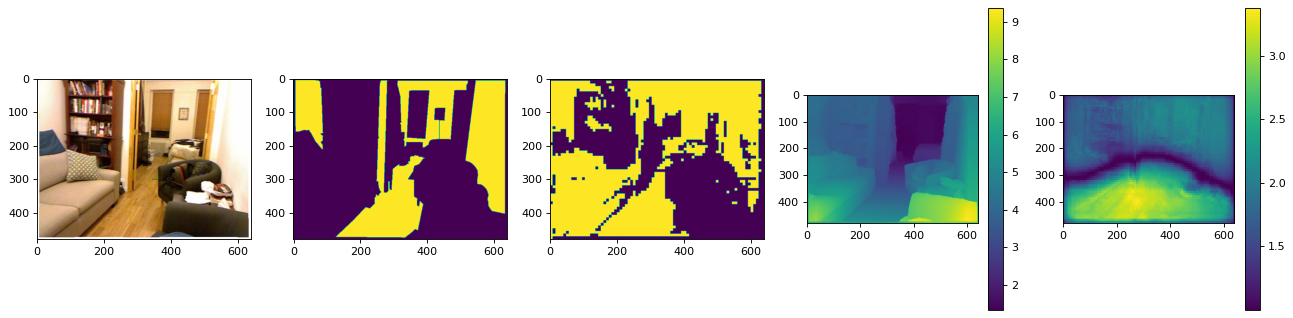

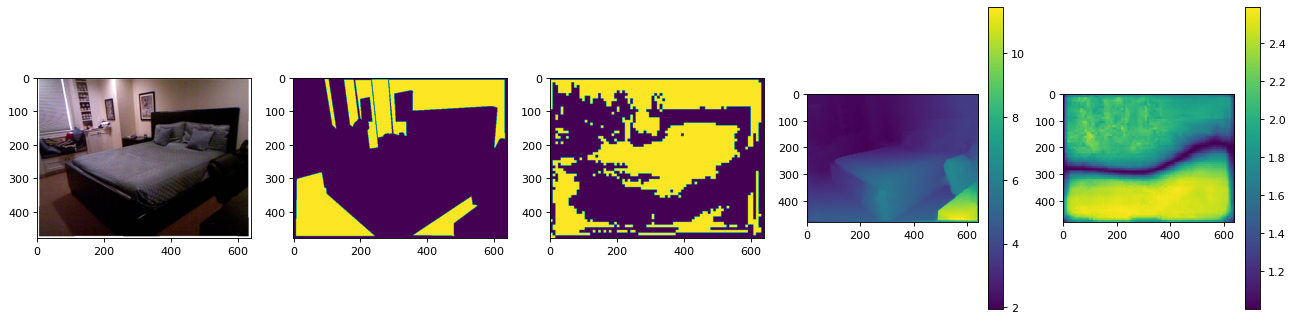

In [10]:
# inverse # squared + 1
directory = '/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_8/'
standardize = False
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_7.h5'), custom_objects={'tf': tf})
for entry in nyu_depth_ds.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,5,1)
    plt.imshow(entry['image'])
    plt.subplot(1,5,2)
    plt.imshow(entry['label']['seg'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    # Depth label
    plt.subplot(1,5,4)
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = 10 / depth_norm_2#
    if standardize:
        depth_norm_2 = tf.image.per_image_standardization(depth_norm_2)
    ax1 = plt.imshow(depth_norm_2)
    figure.colorbar(ax1)
    label_depth = tf.expand_dims(depth_norm_2,0)
    
    # Depth predictions
    plt.subplot(1,5,5)
    ax2 = plt.imshow(depth[0,:,:])
    figure.colorbar(ax2)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    #pred_depth = tf.keras.activations.relu(pred_depth)
    
    #print(ignorant_depth_loss(label_depth, pred_depth))

### Binning (not implemented)

tf.Tensor([0.96344876], shape=(1,), dtype=float32)
tf.Tensor([1.0007809], shape=(1,), dtype=float32)
tf.Tensor([0.8589022], shape=(1,), dtype=float32)
tf.Tensor([0.90392065], shape=(1,), dtype=float32)
tf.Tensor([0.83804786], shape=(1,), dtype=float32)


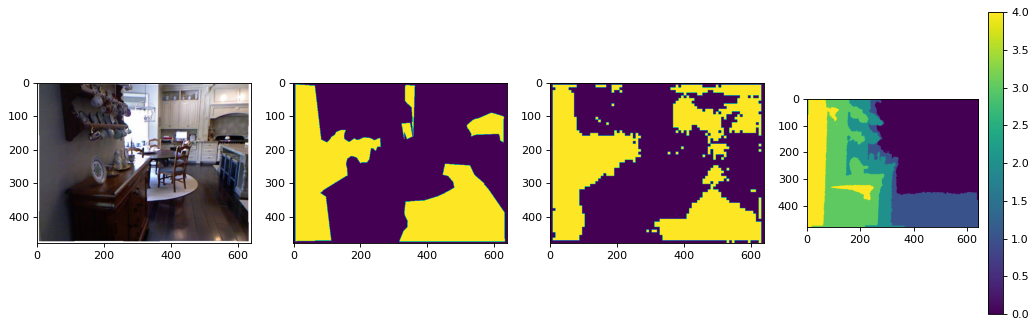

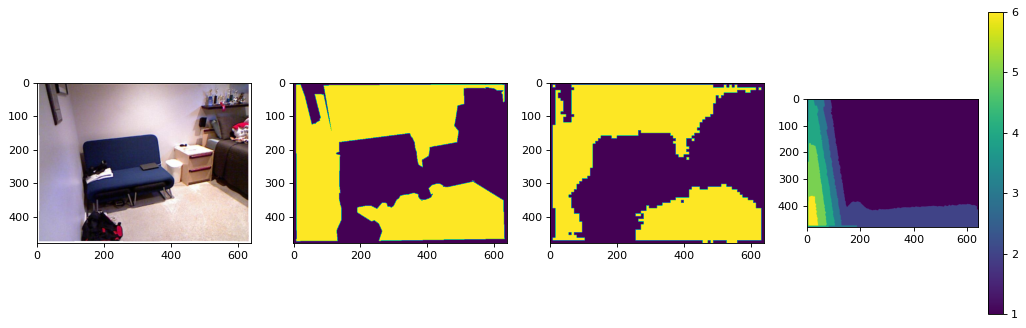

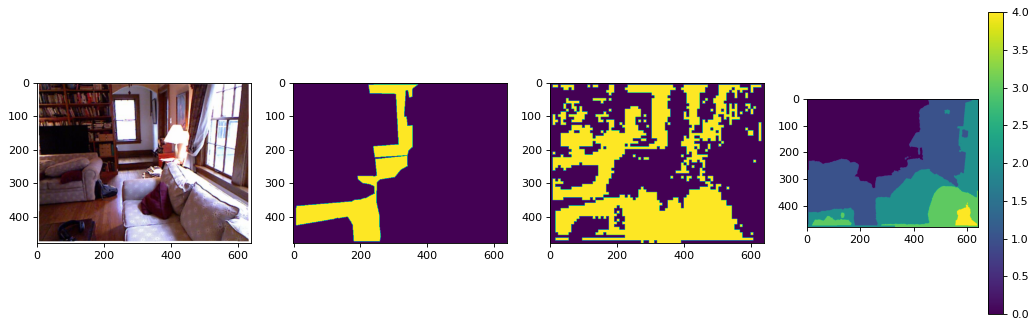

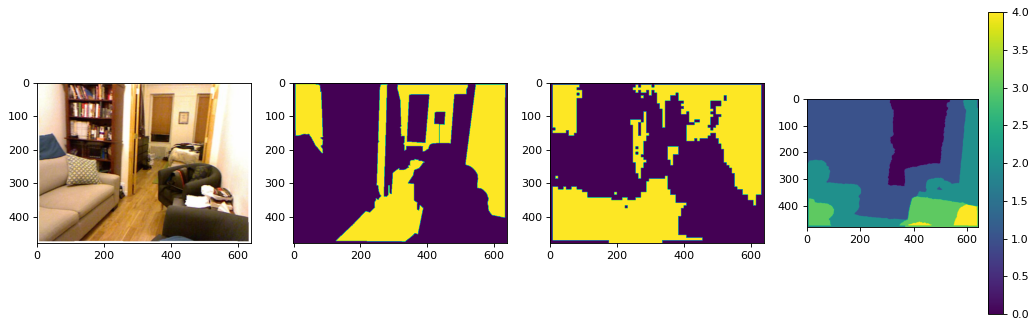

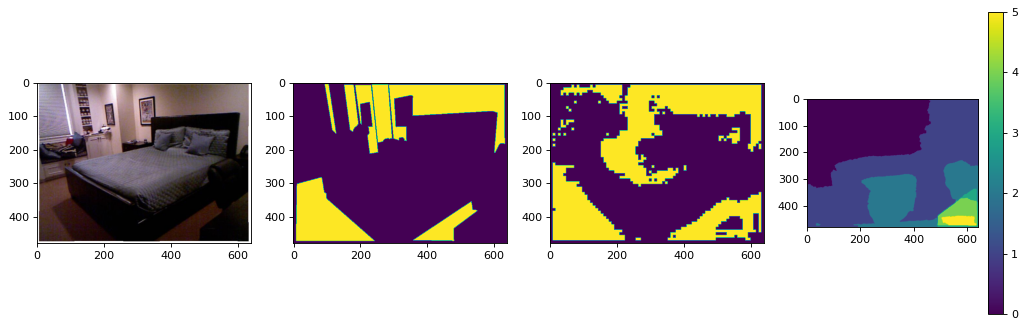

In [26]:
# binning
model0 = tf.keras.models.load_model(os.path.join(directory, 'model_epoch_20.h5'), custom_objects={'tf': tf})
for entry in nyu_depth_ds.take(5):
    figure = plt.figure(figsize=(20, 5), dpi=80)
    plt.subplot(1,5,1)
    plt.imshow(entry['image'])
    plt.subplot(1,5,2)
    plt.imshow(entry['label']['seg'])
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    depth = b[2]
    pred = tf.argmax(semseg, axis=-1)
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    # Depth label
    plt.subplot(1,5,4)
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = 10 / depth_norm_2
    value_range = [1.0, 20.0]
    indices = tf.histogram_fixed_width_bins(depth_norm_2, [1.0, 20.0], nbins=10)
    ax1 = plt.imshow(indices)
    figure.colorbar(ax1)
    label_depth = tf.expand_dims(depth_norm_2,0)
    
    # Depth predictions
    #plt.subplot(1,5,5)
    #ax2 = plt.imshow(depth[0,:,:])
    #figure.colorbar(ax2)
    #pred_depth = tf.expand_dims(depth[0,:,:],0)
    #pred_depth = tf.keras.activations.relu(pred_depth)
    
    print(ignorant_depth_loss(label_depth, pred_depth))